In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import scipy.stats as stats
import math
import sklearn.preprocessing
from env import get_db_url

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# train test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

#import acquire
import explore as e
import wrangle_zillow as w
import modeling as m 
#import NAME OF MODEL IMPORT as m

import warnings
warnings.filterwarnings("ignore")


* I acquired this data from the Codeup database using mySQL workbench
* Each observation or row provides a value or description of a home
* Each column represents a feature of the property
* I acquired this data on Wednesday November 15th 

# Prepare

* Removed nulls from rows then removed columns with most nulls
* Year built column changed to age and imputed values to show age of property
* Split data into train, validate and test(approx. 50/30/20)
* Renamed multiple columns : bedrooms, bathrooms, complete square footage 
* Encoded fips values to reperesent county name

 

In [2]:
#create, train, validate, test datasets
df = w.get_zillow_data()


In [3]:
columns = ['buildingqualitytypeid','heatingorsystemdesc','heatingorsystemtypeid','unitcnt','propertyzoningdesc','propertylandusedesc','parcelid.1','id.1','censustractandblock']
location = ['latitude','longitude','age']
foundation = ['sqft','lotsizesquarefeet']

In [4]:
df = w.data_prep(df,columns)

In [5]:
#create, train, validate, test datasetsb
train, validate, test = w.wrangle_zillow(df)

In [6]:
train

,propertylandusetypeid,parcelid,id,baths,beds,calculatedbathnbr,sqft,finishedsquarefeet12,fips,fullbathcnt,...,total_rooms,age,structuretaxvaluedollarcnt,property_value,assessmentyear,landtaxvaluedollarcnt,taxamount,max_transactiondate,logerror,transactiondate
13535,261.0,12397906,66906,1.0,2.0,1.0,872.0,872.0,6037.0,1.0,...,0.0,1951.0,66570.0,332867.0,2016.0,266297.0,4357.93,2017-03-24,0.026998,2017-03-24
30453,261.0,14380619,2800936,3.0,3.0,3.0,2260.0,2260.0,6059.0,3.0,...,8.0,1976.0,204282.0,346335.0,2016.0,142053.0,3515.14,2017-06-09,0.037181,2017-06-09
13337,261.0,12902896,1127949,2.0,3.0,2.0,1091.0,1091.0,6037.0,2.0,...,0.0,1961.0,75710.0,126352.0,2016.0,50642.0,1893.90,2017-03-24,0.019205,2017-03-24
7660,261.0,11568321,2658421,6.0,5.0,6.0,4783.0,4783.0,6037.0,6.0,...,0.0,2013.0,1693460.0,3981978.0,2016.0,2288518.0,47785.18,2017-02-22,0.037875,2017-02-22
34175,261.0,13100555,1758804,5.0,5.0,5.0,4425.0,4425.0,6037.0,5.0,...,0.0,1999.0,720626.0,1261091.0,2016.0,540465.0,14379.50,2017-06-27,0.002652,2017-06-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38066,261.0,14238880,638264,2.0,3.0,2.0,1611.0,1611.0,6059.0,2.0,...,6.0,1961.0,106597.0,654836.0,2016.0,548239.0,7041.04,2017-07-12,-0.006377,2017-07-12
48425,261.0,12438510,2110521,3.0,5.0,3.0,2652.0,2652.0,6037.0,3.0,...,0.0,1965.0,374482.0,789078.0,2016.0,414596.0,9365.87,2017-08-30,-0.008494,2017-08-30
19647,261.0,11508139,2077101,2.0,3.0,2.0,1962.0,1962.0,6037.0,2.0,...,0.0,1951.0,119815.0,396237.0,2016.0,276422.0,4630.60,2017-04-25,0.680864,2017-04-25
21717,261.0,14314819,161303,2.0,3.0,2.0,1714.0,1714.0,6059.0,2.0,...,6.0,1971.0,139951.0,411286.0,2016.0,271335.0,4590.46,2017-05-03,0.038707,2017-05-03


# Exploration of Data

### What is the median and mean logerror? 

In [7]:
# table of logerror mean and median
e.statistic_table(df)

Metric           Value
----------  ----------
Median      0.00684291
Mean        0.0181363
Difference  0.0112934


### Takeaways

- The median logerror is .0069
- The mean logerror is .018
- The difference between these values is .011

# Statistical Questions

### Is there a signfiicant difference in mean logerror across the three counties?

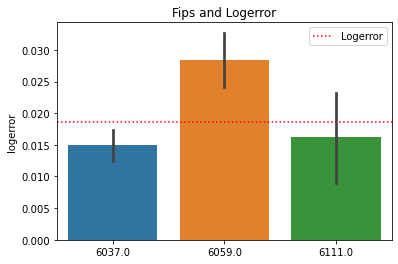

In [8]:
# creates bar chart of logerror
e.bar_chart(train,'fips','logerror')

### Hypothesis

- Ho: There is not a signficant difference in mean between logerror across counties<br>
- Ha: There is a significant difference in mean  between logerror across counties

In [9]:
# Statistical test results
e.stats_property_location(train)

Kruska Result = 53.2321
p = 2.7592338397679317e-12


### Takeaways 

- The counties have signficant differences in their mean log errors
- Orange county appears to have the largest mean logerror
a



### Is there a correlation between taxamount and logerror?

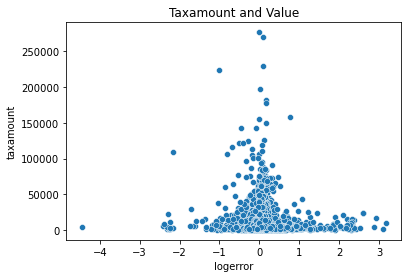

In [10]:
# Visualization 
e.scatter_plot(train)

### Hypothesis: 

Ho: There is is not a correlation between logerror and taxamount<br>
Ha: There is a correlation between logerror and taxamount

In [11]:
# Statistcal test results
e.correlation_stat_test(train,'taxamount')

Correlation Strength = -0.0143
p = 0.01603980724302495


### Takeaways
- There is a correlation beetween the taxamount and the logerror
- As the price of the home increases the log error decreases 




### Is there a significant difference in the mean logerror of homes in the location cluster number one compared to the population?

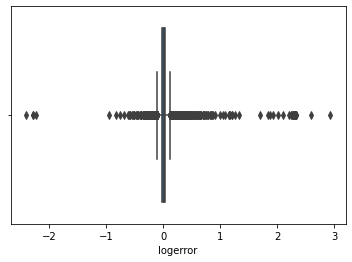

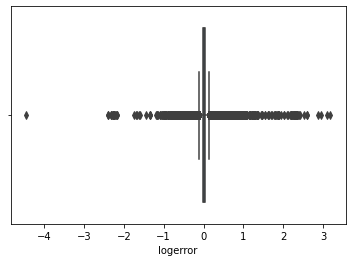

In [12]:
# Visualization
e.boxplots(train,location,5,1)

### Hypothesis: 

Ho: There is not a significant difference in the mean logerror of homes in foundation cluster number two compared to the population<br>
Ha: There is a significant difference in the mean logerror of homes in foundation cluster number two compared to the population

In [13]:
# Statistical test results 
e.ttest(train,location,5,1)

We reject $H_{0}$


(3.9215866859077404, 8.909651845831881e-05)

### Takeaways

- Rejecting the null here implies that this cluster could be a useful feature to help the performance of our model as the mean log error in this cluster is significantly different from the overall popultaion.


### Is there a significant difference in the mean logerror of homes in the location cluster number two compared to the population?

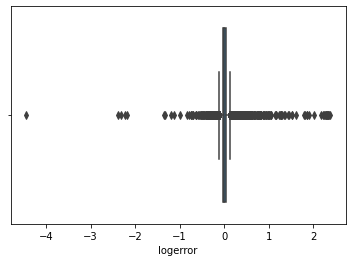

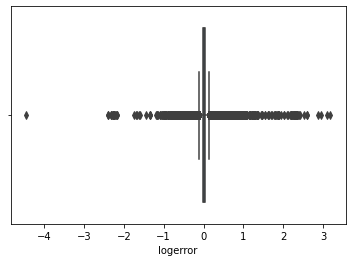

In [14]:
# visualization
# Visualization
e.boxplots(train,location,5,2)

### Hypothesis

Ho: There is not a significant difference in the mean logerror of homes in the location cluster number one compared to the population<br>
Ha: There is a significant difference in the mean logerror of homes in the location cluster number one compared to the population

In [15]:
# Statistical test results 
e.ttest(train,location,5,2)

We reject $H_{0}$


(2.0792505008757365, 0.03762105270215126)

### Takeaways
- Rejecting the null here implies that this cluster could be a useful feature to help the performance of our model as the mean log error in this cluster is significantly different from the overall popultaion.


## Exploration Summary

- The median logerror is .0069
- The counties have signficant differences in their mean log errors
- As the price of the home increases the log error decreases 
- Properties within location cluster 1 have a different mean log error to the population
- Properties within location cluster 2 have a different mean log error to the population







# Modeling

### Introduction

- I will use Root Mean Squared error as my evaluation metric
- My baseline model is created from the Root Mean Squared error (RMSE) of the median logerror of the train and validate data set
- The features chosen for the models are FILL IN FEATURES
- Models will be evaluated on train and validate data sets 
- The model that performs the best will be evaluated on the test data

In [16]:
# prepare data for models
location_train_model_df = m.make_location_model_df(train,location, 5)
location_validate_model_df = m.make_location_model_df(validate,location,5)
location_test_model_df = m.make_location_model_df(test, location, 5)

In [17]:
foundation_train_model_df = m.make_foundation_model_df(train,foundation,4)
foundation_validate_model_df = m.make_foundation_model_df(validate,foundation,4)
foundation_test_model_df = m.make_foundation_model_df(test,foundation,4)

## Baseline Model

In [18]:
# creating baseline model and printing resu
m.baseline(train)

RMSE using Median
Train/In-Sample:  0.18


## LassoLars 

In [19]:
#generating LassoLars modelresults using location features/clusters
m.Lass(location_train_model_df,location_validate_model_df,train,validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17883017849045363 
Validation/Out-of-Sample:  0.1621427261414958


In [20]:
#generating LassoLars model using foundation features/ clusters
m.Lass(foundation_train_model_df,foundation_validate_model_df,train,validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17883017849045363 
Validation/Out-of-Sample:  0.1621427261414958


### Takeaways 
- model performs better than baseline 

## Polynomial Regression 

In [21]:
# generating polynomial regression model results using location features/clusters
m.regression_functions(location_train_model_df,location_validate_model_df,location_test_model_df,train,validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17862222809265554 
Validation/Out-of-Sample:  0.16212781413327454


In [22]:
# generating polynomial regression model results using foundation features/clusters
m.regression_functions(foundation_train_model_df,foundation_validate_model_df,foundation_test_model_df,train,validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17868292180772677 
Validation/Out-of-Sample:  0.16236369379657536


## Takeaways
- performs better than baseline 


## Best Model

- ####   Polynomial Regression Model Wins!

## Test Model
- I will run my Polynomial Regression on my test data

In [23]:
# using model on test dataset 
m.model_test(location_train_model_df,location_validate_model_df,location_test_model_df,validate,test)

RMSE for Polynomial Model, degrees=2
Validate/Out-of-Sample:  0.16186533157889813 
Test/Out-of-Sample:  0.1799204195947181


### Modeling Wrap 

* I would recommend this model for production because it is roughly a 7% improvement from the baseline

## Conclusion

### Summary
- 
- 
- 
- 
- 


### Modeling Summary 
- The model uses 
- The final model performed approximately 7% better than the baseline
- I would recommend this model for production


### Recommendations
* Have a team meeting to discuss how to analyze features specifc to location
* Request more data to balance out the representation of transactions in Orange County and Ventura County 


### Next Steps
* Take time to build a model solely based on location features
* Look further into Los Angeles transactions impact on data